# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ 2 次のトロッターにしてみる
+ GHZ を中心に寄せる。このままだと不要な Trotter gate があるので。

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
n_qubits = 4

initial_state = np.zeros(2**n_qubits, dtype=complex)
initial_state[0] = 1
print(initial_state)

initial_state_2 = Statevector.from_label("0" * n_qubits)
print(initial_state_2.data)

print(np.allclose(initial_state, initial_state_2.data))

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
True


In [ ]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:

# !!!!!!!!!
# DANGER: Do not hardcode your token in your code. Use environment variables instead.
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="YOUR_IBM_QUANTUM_TOKEN",
)
# !!!!!!!!!

# service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['sx', 'reset', 'id', 'x', 'measure', 'cz']>)


# データセット作成 $\exp(-\beta H)$

In [6]:
n_samples = 50
n_qubits = 4
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

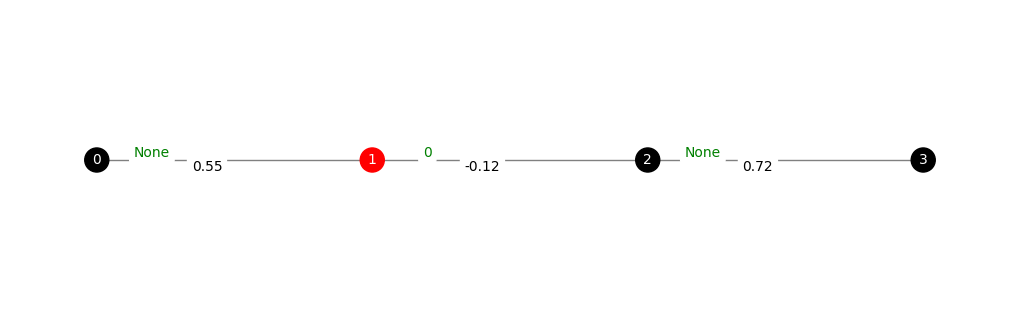

In [7]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [11]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
# index = "1" * (n_qubits // 2) + "0" * (n_qubits // 2)
# print(f"binary index: {index}")

# state = Statevector.from_label(index)
# print(f"index: {int(index, 2)}")
# print(state[int(index, 2)])

In [12]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 0110
decimal: 6
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [13]:
data = []
graphs = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    H = H.to_matrix(sparse=True)
    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y})
    graphs.append(G)

df = pd.DataFrame(data)
df

Sample 0/50
Sample 1/50
Sample 2/50
Sample 3/50
Sample 4/50
Sample 5/50
Sample 6/50
Sample 7/50
Sample 8/50
Sample 9/50
Sample 10/50
Sample 11/50
Sample 12/50
Sample 13/50
Sample 14/50
Sample 15/50
Sample 16/50
Sample 17/50


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Sample 18/50
Sample 19/50
Sample 20/50
Sample 21/50
Sample 22/50
Sample 23/50
Sample 24/50
Sample 25/50
Sample 26/50
Sample 27/50
Sample 28/50
Sample 29/50
Sample 30/50
Sample 31/50
Sample 32/50
Sample 33/50
Sample 34/50
Sample 35/50
Sample 36/50
Sample 37/50
Sample 38/50
Sample 39/50
Sample 40/50
Sample 41/50
Sample 42/50
Sample 43/50
Sample 44/50
Sample 45/50
Sample 46/50
Sample 47/50
Sample 48/50
Sample 49/50


,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",13.899220
1,"[0.3947360581187278, -0.8116453042247009, 0.95...",28.585213
2,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653082
3,"[-0.09922812420886573, -0.25840395153483753, 0...",7.222891
4,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865078
5,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.138950
6,"[0.6552623439851641, 0.2633287982441297, 0.516...",9.060659
7,"[-0.2909480637402633, 0.9413960487898065, 0.78...",4.367027
8,"[0.5567669941475237, -0.6107225842960649, -0.0...",4.566077
9,"[-0.9123924684255424, -0.6914210158649043, 0.3...",3.720380


## Pre-process data

In [14]:
df["expected_value"].describe()

count    50.000000
mean      3.986658
std       4.923363
min       0.527533
25%       1.420761
50%       2.131549
75%       4.205365
max      28.585213
Name: expected_value, dtype: float64

In [15]:
# Query the 80% quantile
q = df["expected_value"].quantile(0.8)
filtered_index = df.query(f"expected_value < @q").index
diffrence = df.index.difference(filtered_index)
print(f"Outliers: {diffrence}")

# Remove outliers
df = df.drop(diffrence).reset_index(drop=True)
graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([0, 1, 3, 6, 13, 14, 24, 33, 43, 46], dtype='int64')


In [16]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value
0,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653082
1,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865078
2,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.138950
3,"[-0.2909480637402633, 0.9413960487898065, 0.78...",4.367027
4,"[0.5567669941475237, -0.6107225842960649, -0.0...",4.566077
5,"[-0.9123924684255424, -0.6914210158649043, 0.3...",3.720380
6,"[0.48952431181563427, 0.93501946486842, -0.348...",1.711405
7,"[-0.25908058793026223, -0.06088837744838416, -...",0.920606
8,"[-0.7401569893290567, -0.04859014754813251, -0...",1.084233
9,"[0.6095287149936037, -0.22504324193965108, -0....",3.526609


Number of samples: 40


count    40.000000
mean      2.061562
std       1.072359
min       0.527533
25%       1.295174
50%       1.860866
75%       2.409074
max       5.025722
Name: expected_value, dtype: float64

## Check eigvals and Configure params

In [17]:
# Plot histogram of eigenvalues
# print(f"Number of samples: {n_samples}")
# eigvals_array = np.array(eigvals_list).flatten()
# plt.hist(eigvals_array, bins=50)
# plt.xlabel("Eigenvalues")
# plt.ylabel("Frequency")
# plt.title("Eigenvalues of Hamiltonian")
# plt.show()

In [18]:
n_features = 5  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
C = 10 * n_qubits  # upper bound for eigenvalues
times = [np.pi * k / C for k in range(n_features)]

# C = max(matrix_norms)  # upper bound for eigenvalues
print(f"C: {C}")
# print(f"max matrix norm: {max(matrix_norms)}")  # For debugging
print(f"times: {times}")

C: 40
times: [0.0, 0.07853981633974483, 0.15707963267948966, 0.23561944901923448, 0.3141592653589793]


In [19]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [20]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
# path = f"./data/{current_time}/{n_qubits}_{backend_qpu.name}_{graph_type}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-01T04:41Z
Saving data to ./data/2024-12-01T04:41Z


In [21]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
    )